# Raggi Cosmici
Generiamo con una simulazione Monte Carlo una distribuzione di raggi cosmici sul nostro apparato sperimentale al fine di stimarne il rate

## Generazione della distribuzione di raggi cosmici

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import ROOT
import array
import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import Functions


La prima cosa da fere è generare punti in due dimensioni, $(\theta, \phi)$, tali che i punti siani distribuiti secondo la legge:

$\displaystyle \frac{\mathrm{d}P}{\mathrm{d}\Omega} = \frac{\mathrm{d}P}{\sin\theta\mathrm{d}\theta\,\mathrm{d}\phi} = k \cos^2\theta$ 

dove $k$ è una costante di normalizzazione e $0\le \theta <\pi/2$

Possiamo anche riscrivere:

$\displaystyle\frac{\mathrm{d}P}{\mathrm{d}\theta\,\mathrm{d}\phi}=f(\theta)\,g(\phi)= k\sin\theta\cos^2\theta$ 

Dove:

$f(\theta)=c_1\sin \theta\cos^2\theta$

$g(\phi) = c_2$

e $k=c_1 c_2$.

La distribuzione cumulativa di $f(\theta)$ è:

$\displaystyle F(\theta) = c_1 \int_{0}^\theta \sin \theta^\prime\cos^2\theta^\prime\,\mathrm{d}\theta^\prime = 
-\frac{c_1}{3}\left[\cos^3\theta^\prime\right]_{\theta^\prime=0}^{\theta^\prime=\theta} = 
\frac{c_1}{3}(1 - \cos^3\theta)$

Il coefficiente di normalizzazionre $c_1$ va posto in modo che sia $F(\pi/2) = 1$:

$\displaystyle 1 = \frac{c_1}{3}\left(1 - \cos^3 \frac{\pi}{2}\right) = \frac{c_1}{3}$

Quindi $c_1 = 3$ e $F(\theta) = 1 - \cos^3\theta$.

$F(\theta)$ va invertita per otterenere $\theta$ dall'equazione: $F(\theta)= r_1$, dove $r_1$ è un numero uniormemente distribuito in $[0,1\,[$:


$\displaystyle\left(1 - \cos^3\theta\right) = r_1$

Da cui:


$\displaystyle\theta = \mathrm{arccos}(\sqrt[3]{1-r_1})\in \left[0, \frac{\pi}{2}\right[$


In [176]:
def cosm_dir():
    return math.acos((1-random.random())**(1/3)), 2*math.pi*random.random()

In [234]:
#Generiamo la distirbuzione di raggi cosmici usando il metodo dell'inversione della cumulativa. 
n = 800
N = 50000
thetas = np.empty(N)
phis = np.empty(N)
us = np.empty(N)
vs = np.empty(N)
ws = np.empty(N)
for i in range(N):
    th, ph = cosm_dir()
    thetas[i], phis[i] = th,ph
    ct, st = math.cos(th), math.sin(th)
    cp, sp = math.cos(ph), math.sin(ph)
    us[i], vs[i], ws[i] = st*cp , st*sp ,ct


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).


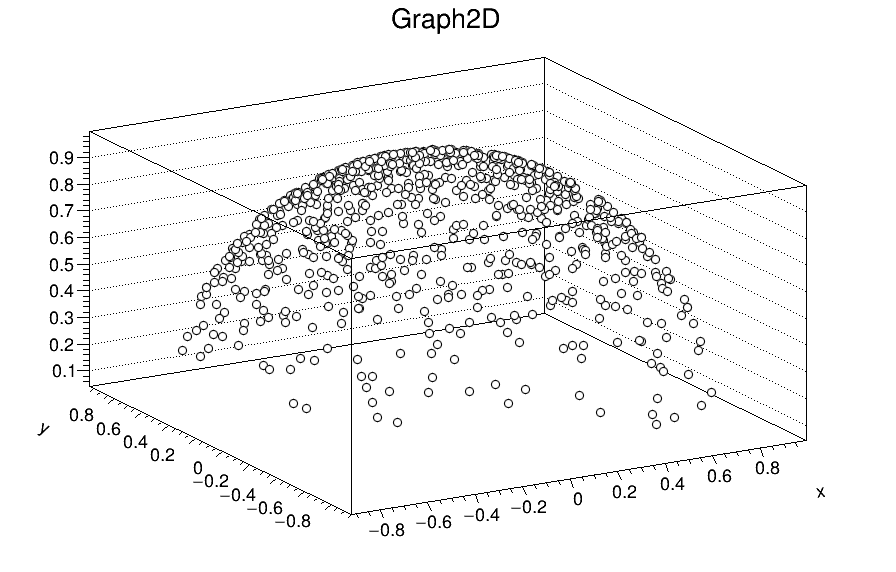

In [235]:
#Creiamo un grafico per "vedere" la distribuzione dei raggi cosmici ne metto solo 100 altrimenti non si capisce niente

nmax = 800
c = ROOT.TCanvas("c1", "raggi cosmici", 0, 0, 900, 600)
g1 = ROOT.TGraph2D(len(us[:nmax]), array.array("f",us[:nmax]), array.array("f",vs[:nmax]), 
                  array.array("f", ws[:nmax]))
g1.GetXaxis().SetTitle("x")
g1.GetXaxis().SetTitleOffset(2)
g1.GetYaxis().SetTitle("y")
g1.GetYaxis().SetTitleOffset(2)
g1.GetZaxis().SetTitle("z")
g1.GetZaxis().SetTitleOffset(2)
g1.Draw()
c.Draw()


## Visualizzazione di raggi cosmici che impattano su un piano


In [236]:
#Costruiamo dei punti di impatto in maniera randomica. In particolare vogliamo rappresentare i raggi
#che impattano su un piano con z=0 di 1m x 1m

xs, ys, zs = np.random.uniform(0,1,N), np.random.uniform(0,1,N), np.zeros(N)


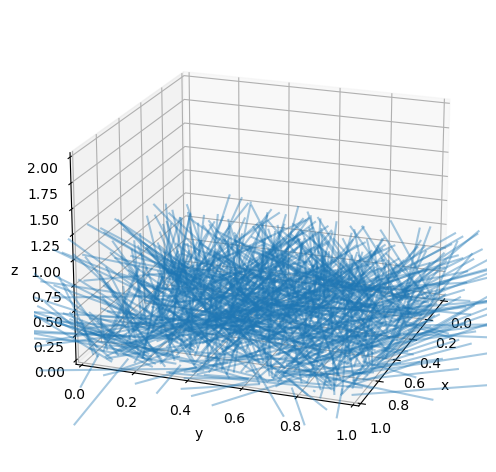

In [237]:

fig = plt.figure(figsize=(6,6),dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 20)
ax.set_xlim3d(0,1)
ax.set_ylim3d(0,1)
ax.set_zlim3d(0,2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.quiver(xs[:n], ys[:n], zs[:n], us[:n], vs[:n], ws[:n], length=0.6, arrow_length_ratio=0,
          normalize=True, alpha=0.4)
plt.show()

In [238]:
#Questa funzione serve per costruire il cubo
def cuboid_data2(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    
    return X

def createSolid(sizes,positions, quota = 0, fillColor='#0000ff20', edgeColor='#0000ff',getImpactPlane = False, N=1000):
    
    '''
    a,b,c: lunghezze dei lati
    quota: altezza iniziale
    fillColor, edgeColor: colore di riempimento e di linea di contorno (il default è blu)
    getImpacPlane: ritorna array con N punti generati in accordo alla figura
    N: deve essere uguale al numero di eventi generato (se si vuole calcolare il rate di coincidenze)
    '''
   
    solid =a3.art3d.Poly3DCollection(cuboid_data2(positions,sizes))
    solid.set_color(fillColor)
    solid.set_edgecolor(edgeColor)
    if not getImpactPlane: 
        return solid
    else:
        c= solid._vec
        x = np.random.uniform(c[0].min(), c[0].max(), N)
        y = np.random.uniform(c[1].min(), c[1].max(), N)
        return solid, x, y


In [239]:


#tuk, xt, yt = createSolid([26,51.9,14.2], [0,11.3,9.1], 
 #                 fillColor= "#ff4dff20", edgeColor=  '#ff4bff',
  #                        getImpactPlane= True, N = n)
#ax.add_collection3d(tuk)




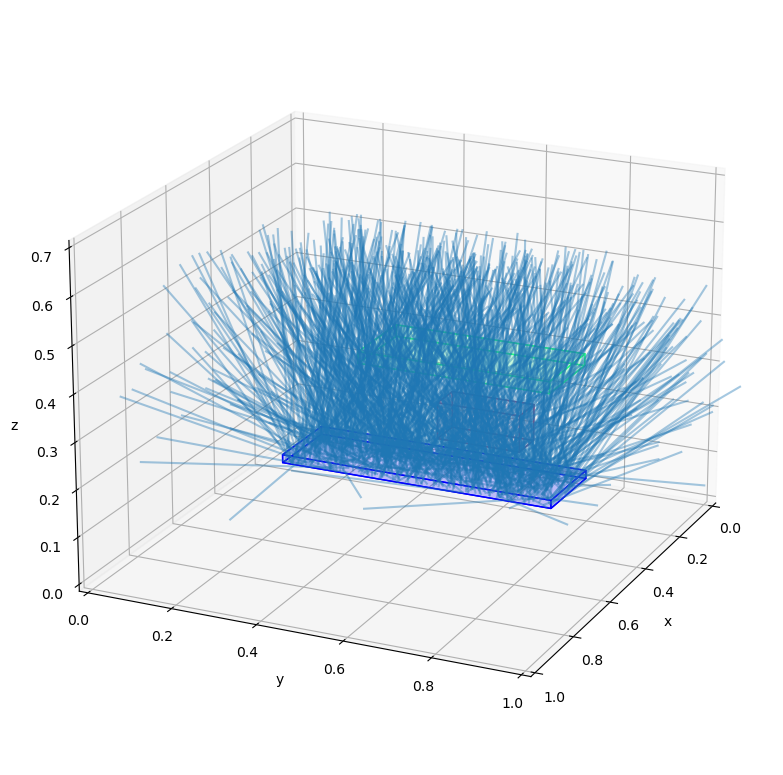

In [240]:
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 25)

xmin,xmax = 0,1
ymin,ymax  = 0,1
zmin,zmax = 0,0.7

ax.set_xlim3d(xmin, xmax)
ax.set_ylim3d(ymin, ymax)
ax.set_zlim3d(zmin,zmax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#Adesso inseriamo le dimensioni dei tre lati e i punti di minimo di ogni lato
a_dw, b_dw, c_dw  = 0.201,0.665,0.018
x0_dw, y0_dw, z0_dw = 0,0.05,0

#La funzione che segue crea il solido che viene inserito poi nel plot. Gli output x_dw e y_dw danno 
#una distirbuzione conforme alla figura costruita 
s_dw,x_dw,y_dw = createSolid([a_dw,b_dw,c_dw],[x0_dw,y0_dw,z0_dw], getImpactPlane = True, N = N)
ax.add_collection3d(s_dw)
z_dw = np.full(x_dw.shape[0], 0)

a_up,b_up,c_up = 0.201,0.466,0.026
x0_up,y0_up,z0_up = 0,0.242,0.252
s_up,x_up,y_up = createSolid([a_up,b_up,c_up],[x0_up,y0_up,z0_up], fillColor = "#24ff8120", edgeColor = '#24ff81',
                         getImpactPlane = True, N= N)
ax.add_collection3d(s_up)


a_cs,b_cs, c_cs = 0.08,0.20,0.08
x0_cs,y0_cs,z0_cs = 0.09,0.424,0.101
csi, x_cs,y_cs = createSolid([a_cs,b_cs,c_cs], [x0_cs,y0_cs,z0_cs], 
                  fillColor = "#884e8420", edgeColor = '#884e84', 
                        getImpactPlane = True, N= N)
ax.add_collection3d(csi)

#Qua creiamo dei raggi cosmici che passino per lo scintillatore down
ax.quiver(x_dw[:n], y_dw[:n], z_dw[:n], us[:n], vs[:n], ws[:n], length=0.5, arrow_length_ratio=0,
          normalize=True, alpha=0.4)

plt.show()


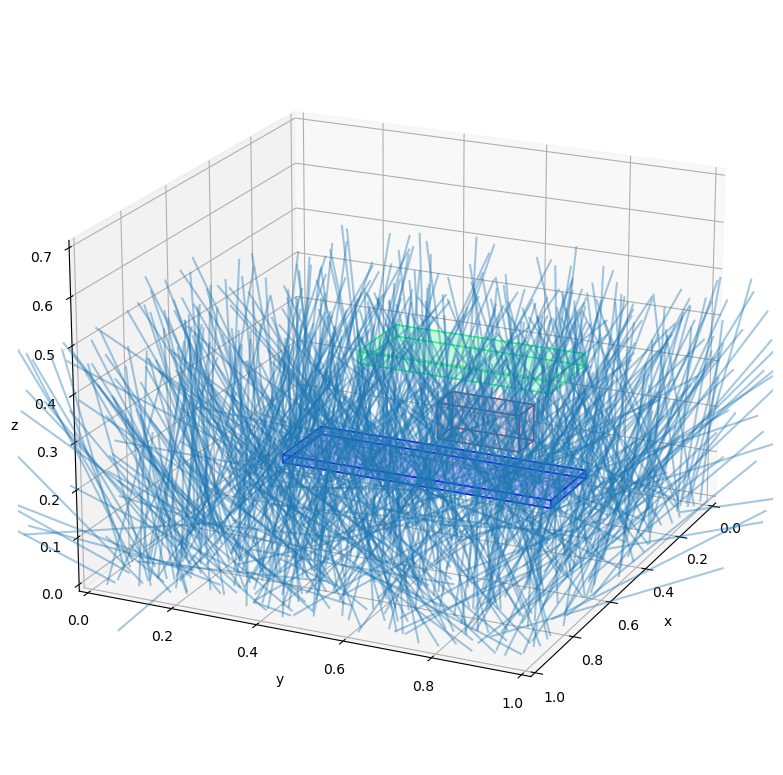

In [241]:
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 25)

ax.set_xlim3d(xmin, xmax)
ax.set_ylim3d(ymin, ymax)
ax.set_zlim3d(zmin,zmax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


#Adesso inseriamo le dimensioni dei tre lati e i punti di minimo di ogni lato
a_dw, b_dw, c_dw  = 0.201,0.665,0.018
x0_dw, y0_dw, z0_dw = 0,0.05,0
s_dw,x_dw,y_dw = createSolid([a_dw,b_dw,c_dw],[x0_dw,y0_dw,z0_dw], getImpactPlane = True, N = N)
ax.add_collection3d(s_dw)
z_dw = np.full(x_dw.shape[0], 0)

a_up,b_up,c_up = 0.201,0.466,0.026
x0_up,y0_up,z0_up = 0,0.242,0.252
s_up,x_up,y_up = createSolid([a_up,b_up,c_up],[x0_up,y0_up,z0_up], fillColor = "#24ff8120", edgeColor = '#24ff81',
                         getImpactPlane = True, N= N)
ax.add_collection3d(s_up)


a_cs,b_cs, c_cs = 0.08,0.20,0.08
x0_cs,y0_cs,z0_cs = 0.09,0.424,0.101
csi, x_cs,y_cs = createSolid([a_cs,b_cs,c_cs], [x0_cs,y0_cs,z0_cs], 
                  fillColor = "#884e8420", edgeColor = '#884e84', 
                        getImpactPlane = True, N= N)
ax.add_collection3d(csi)

xs, ys, zs = np.random.uniform(0,1,N), np.random.uniform(0,1,N), np.zeros(N)

#Qua creiamo dei raggi cosmici che passino per dei punti random su un piano 1mx1m
ax.quiver(xs[:n], ys[:n], zs[:n], us[:n], vs[:n], ws[:n], length=0.5, arrow_length_ratio=0,
          normalize=True, alpha=0.4)

plt.show()


Abbiamo generato i raggi cosmici in modo che passino per il piano a quota $z_0=0\mathrm{m}$. 

Per ogni raggio cosmico, dobbiamo calcolare l'intersezione con il piano superiore e verificare che sia entro la geometria del piano.

Un punto sul raggio cosmico è stato parametrizzato come:

$\vec{r} = \vec{r_0} + l\, \vec{u}$.

Il punto di impatto sul piano a quota $h$ si trova risolvendo l'equazione:

$z_0 + l\, u_z = l\, u_z = h$

$l$ si ottiene semplicemente come:

$\displaystyle l = \frac{h}{u_z}$

Trovata $l$, dobbiamo verificare che il punto $\vec{r_0} + l\,\vec{u}$ abbia coordinate $x$ e $y$ entro il piano.


Quindi: 

$\displaystyle x_{\mathrm{min}} < {x_0} + \frac{h\, u_x}{u_z} < x_{\mathrm{max}}$

$\displaystyle y_{\mathrm{min}} < {y_0} + \frac{h\, u_y}{u_z} < y_{\mathrm{max}}$

## Coincidenza tripla

In [242]:
#Adesso vogliamo vedere quanti raggi intersecano i 3 rivelatori. PEr farlo
#Costruiamo le variabili delle quote dei piani superiori e inferiori 
#Per tutti e tre gli scintillatori. 

a_dw, b_dw, c_dw  = 0.201,0.665,0.018
x0_dw, y0_dw, z0_dw = 0,0.05,0
a_up,b_up,c_up = 0.201,0.466,0.026
x0_up,y0_up,z0_up = 0,0.242,0.252
a_cs,b_cs, c_cs = 0.08,0.20,0.08
x0_cs,y0_cs,z0_cs = 0.09,0.424,0.101

quotasup_cs = z0_cs + c_cs
quotainf_cs = z0_cs
quotasup_up = z0_up + c_up
quotainf_up = z0_up
quotasup_dw = z0_dw + c_dw
quotainf_dw = z0_dw

#Prendiamo i punti dei raggi che partono dai punti del dw  arrivano alle quote degli altri scintillatori
top_upx = x_dw + quotasup_up*us/ws 
top_upy = y_dw + quotasup_up*vs/ws
top_upz = np.full(N, quotasup_up)

top_csx = x_dw + quotasup_cs*us/ws 
top_csy = y_dw + quotasup_cs*vs/ws
top_csz = np.full(N, quotasup_cs)

hits_dw = ((x0_up   < top_upx)         &
           (top_upx < (x0_up + a_up))  &
           (y0_up   < top_upy)         &
           (top_upy < (y0_up + b_up))  &
           (x0_cs   < top_csx)         &
           (top_csx < (x0_cs + a_cs))  &
           (y0_cs   < top_csy)         &
           (top_csy < (y0_cs + b_cs)))
    
colors_dw = ["red" if hit else "cornflowerblue" for hit in hits_dw]
print(len(top_upz))
print((top_upx[hits_dw][:2]))
print(n)

50000
[0.09185731 0.08379497]
800


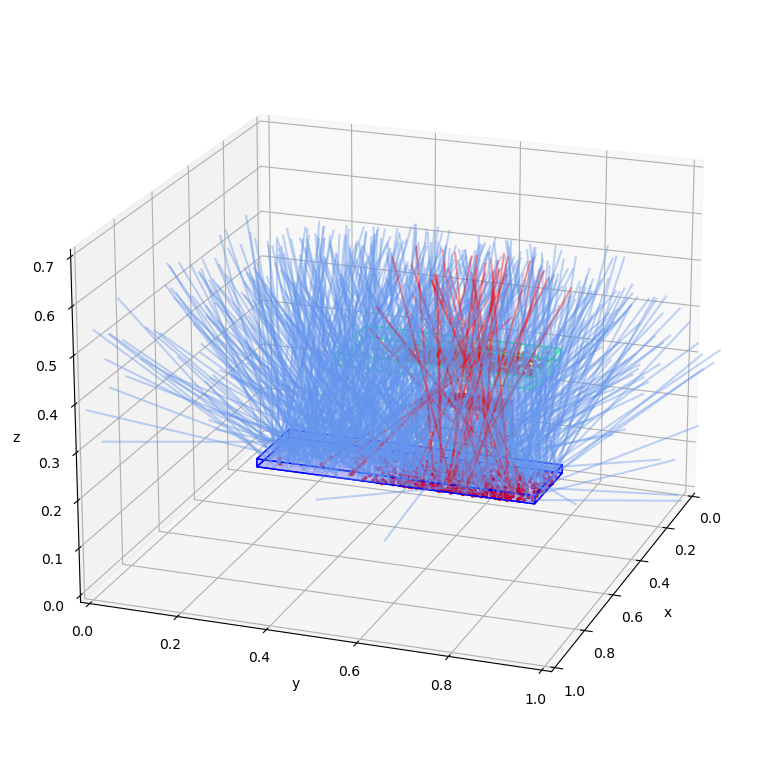

Il numero di raggi che fanno la tripla è 2927 / 50000


In [243]:
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 20)

ax.set_xlim3d(xmin, xmax)
ax.set_ylim3d(ymin, ymax)
ax.set_zlim3d(zmin,zmax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.quiver(x_dw[:n], y_dw[:n], z_dw[:n], us[:n], vs[:n], ws[:n], length=0.5, arrow_length_ratio=0,
normalize=True, color=colors_dw, alpha=0.4)

ax.scatter(x_dw[hits_dw][:n], y_dw[hits_dw][:n], z_dw[hits_dw][:n], s=4, color='red')
ax.scatter(top_upx[hits_dw][:n], top_upy[hits_dw][:n], top_upz[hits_dw][:n], s=4, color='red')
ax.scatter(top_csx[hits_dw][:n], top_csy[hits_dw][:n], top_csz[hits_dw][:n], s=4, color='red')


sdw_plt= createSolid([a_dw,b_dw,c_dw],[x0_dw,y0_dw,z0_dw], getImpactPlane = False, N = n)
ax.add_collection3d(sdw_plt)

sup_plt= createSolid([a_up,b_up,c_up],[x0_up,y0_up,z0_up], fillColor = "#24ff8120", edgeColor = '#24ff81',
                         getImpactPlane = False, N= n)
ax.add_collection3d(sup_plt)

csi_plt= createSolid([a_cs,b_cs,c_cs], [x0_cs,y0_cs,z0_cs], fillColor = "#884e8420", edgeColor = '#884e84', 
                        getImpactPlane = False, N= n)
ax.add_collection3d(csi_plt)

plt.show()
print("Il numero di raggi che fanno la tripla è", np.count_nonzero(hits_dw), '/', hits_dw.shape[0])
#print(len(x_dw[hits_dw]))

In [244]:
#Facciamo la stessa cosa di prima ma considerando i raggi generati da un
#piano 1mx1m

a_dw, b_dw, c_dw  = 0.201,0.665,0.018
x0_dw, y0_dw, z0_dw = 0,0.05,0
a_up,b_up,c_up = 0.201,0.466,0.026
x0_up,y0_up,z0_up = 0,0.242,0.252
a_cs,b_cs, c_cs = 0.08,0.20,0.08
x0_cs,y0_cs,z0_cs = 0.09,0.424,0.101

quotasup_cs = z0_cs + c_cs
quotainf_cs = z0_cs
quotasup_up = z0_up + c_up
quotainf_up = z0_up
quotasup_dw = z0_dw + c_dw
quotainf_dw = z0_dw

#Prendiamo i punti dei raggi che partono dai punti del dw  arrivano alle quote degli altri scintillatori
top_upx_plane = xs + quotasup_up*us/ws 
top_upy_plane = ys + quotasup_up*vs/ws
top_upz_plane = np.full(N, quotasup_up)

top_csx_plane = xs + quotasup_cs*us/ws 
top_csy_plane = ys + quotasup_cs*vs/ws
top_csz_plane = np.full(N, quotasup_cs)

top_dwx_plane = xs + quotasup_dw*us/ws
top_dwy_plane = ys + quotasup_dw*vs/ws
top_dwz_plane = np.full(N, quotasup_dw)

hits_plane = ( (x0_up   < top_upx_plane)         &
               (top_upx_plane < (x0_up + a_up))  &
               (y0_up   < top_upy_plane)         &
               (top_upy_plane < (y0_up + b_up))  &
              
               (x0_cs   < top_csx_plane)         &
               (top_csx_plane < (x0_cs + a_cs))  &
               (y0_cs   < top_csy_plane)         &
               (top_csy_plane < (y0_cs + b_cs))  &
              
               (x0_dw   < (top_dwx_plane))       & 
               (top_dwx_plane < (x0_dw + a_dw))  &
               (y0_dw   < (top_dwy_plane))       &
               (top_dwy_plane < (y0_dw+b_dw)))
            


colors_plane = ["red" if hit else "cornflowerblue" for hit in hits_plane]


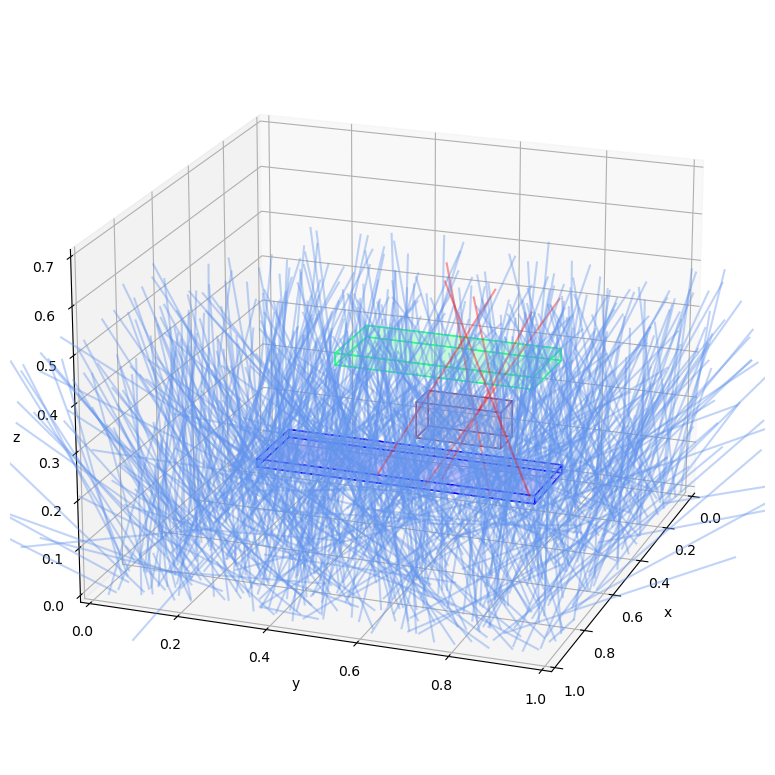

Il numero di raggi che fanno la tripla è 382 / 50000


In [245]:
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 20)

ax.set_xlim3d(xmin, xmax)
ax.set_ylim3d(ymin, ymax)
ax.set_zlim3d(zmin,zmax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.quiver(xs[:n], ys[:n], zs[:n], us[:n], vs[:n], ws[:n], length=0.5, arrow_length_ratio=0,
normalize=True, color=colors_plane, alpha=0.4)
#hits_planen =hits_plane[:n]
#ax.scatter(top_dwx_plane[:n][hits_planen], top_dwy_plane[hits_plane][:n], top_dwz_plane[hits_plane][:n], s=4, color='red')
#ax.scatter(top_upx_plane[:n][hits_planen], top_upy_plane[hits_plane][:n], top_upz_plane[hits_plane][:n], s=4, color='red')
#ax.scatter(top_csx_plane[:n][hits_planen], top_csy_plane[hits_plane][:n], top_csz_plane[hits_plane][:n], s=4, color='red')


sdw_plt= createSolid([a_dw,b_dw,c_dw],[x0_dw,y0_dw,z0_dw], getImpactPlane = False, N = n)
ax.add_collection3d(sdw_plt)

sup_plt= createSolid([a_up,b_up,c_up],[x0_up,y0_up,z0_up], fillColor = "#24ff8120", edgeColor = '#24ff81',
                         getImpactPlane = False, N= n)
ax.add_collection3d(sup_plt)

csi_plt = createSolid([a_cs,b_cs,c_cs], [x0_cs,y0_cs,z0_cs], fillColor = "#884e8420", edgeColor = '#884e84', 
                        getImpactPlane = False, N= n)
ax.add_collection3d(csi_plt)

plt.show()
print("Il numero di raggi che fanno la tripla è", np.count_nonzero(hits_plane), '/', hits_plane.shape[0])





## Singole del CSI

In [246]:
#Ora vogliamo vedere quanti urtano solo il CSI. PEr farlo facciamo tutto come prima prendendo in considerazione
#quota inferiore e superiore del CSI

quotasup_cs = z0_cs + c_cs
quotainf_cs = z0_cs

top_csx_plane = xs + quotasup_cs*us/ws 
top_csy_plane = ys + quotasup_cs*vs/ws
top_csz_plane = np.full(N, quotasup_cs)

bot_csx_plane = xs + quotainf_cs*us/ws 
bot_csy_plane = ys + quotainf_cs*vs/ws
bot_csz_plane = np.full(N, quotainf_cs)

hits_cs_top =   ((x0_cs   < top_csx_plane)         &
                 (top_csx_plane < (x0_cs + a_cs))  &
                 (y0_cs   < top_csy_plane)         &
                 (top_csy_plane < (y0_cs + b_cs)))
                 
hits_cs_bot =   ((x0_cs   < bot_csx_plane)         &
                 (bot_csx_plane < (x0_cs + a_cs))  &
                 (y0_cs   < bot_csy_plane)         &
                 (bot_csy_plane < (y0_cs + b_cs)))

hits_cs_plane = hits_cs_top + hits_cs_bot 
colors_cs_plane = ['red' if hit else 'cornflowerblue' for hit in hits_cs_plane]

#
#print(hits_cs_bot[155:165])
#print(hits_cs_top[155:165])
#print(hits_cs_bot[155:165] + hits_cs_top[155:165])

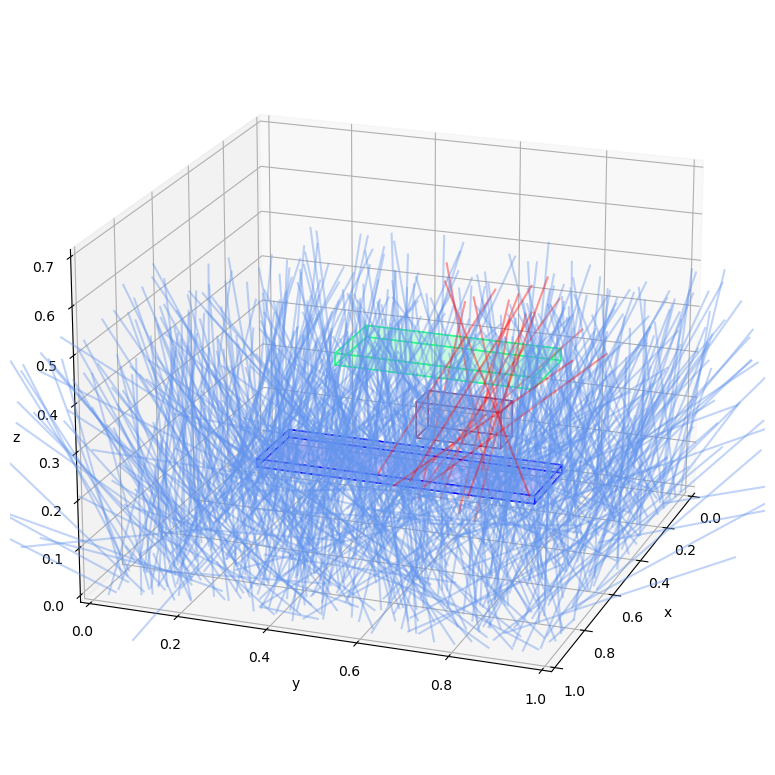

Il numero di raggi che prendono il CsI è 1101 / 50000


In [247]:
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 20)

ax.set_xlim3d(xmin, xmax)
ax.set_ylim3d(ymin, ymax)
ax.set_zlim3d(zmin, zmax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.quiver(xs[:n], ys[:n], zs[:n], us[:n], vs[:n], ws[:n], length=0.5, arrow_length_ratio=0,
normalize=True, color=colors_cs_plane, alpha=0.4)

#ax.scatter(top_csx_plane[hits_cs_plane], top_csy_plane[hits_cs_plane], top_csz_plane[hits_cs_plane], s=4, color='red')
#ax.scatter(bot_csx_plane[hits_cs_plane], bot_csy_plane[hits_cs_plane], bot_csz_plane[hits_cs_plane], s=4, color='red')

sdw_plt= createSolid([a_dw,b_dw,c_dw],[x0_dw,y0_dw,z0_dw], getImpactPlane = False, N = n)
ax.add_collection3d(sdw_plt)

sup_plt= createSolid([a_up,b_up,c_up],[x0_up,y0_up,z0_up], fillColor = "#24ff8120", edgeColor = '#24ff81',
                         getImpactPlane = False, N= n)
ax.add_collection3d(sup_plt)

csi_plt = createSolid([a_cs,b_cs,c_cs], [x0_cs,y0_cs,z0_cs], fillColor = "#884e8420", edgeColor = '#884e84', 
                        getImpactPlane = False, N= n)
ax.add_collection3d(csi_plt)

plt.show()

print('Il numero di raggi che prendono il CsI è', np.count_nonzero(hits_cs_plane), '/', hits_cs_plane.shape[0])

## Falsi stop
Nel nostor caso gli stop sono 3: 010, 011, 110. Vogliamo vedere quanti di questi falsi stop sono presenti
nella nostra acquisizione.

In [248]:
a_dw, b_dw, c_dw  = 0.201,0.665,0.018
x0_dw, y0_dw, z0_dw = 0,0.05,0
a_up,b_up,c_up = 0.201,0.466,0.026
x0_up,y0_up,z0_up = 0,0.242,0.252
a_cs,b_cs, c_cs = 0.08,0.20,0.08
x0_cs,y0_cs,z0_cs = 0.09,0.424,0.101

quotasup_cs = z0_cs + c_cs
quotainf_cs = z0_cs
quotasup_up = z0_up + c_up
quotainf_up = z0_up
quotasup_dw = z0_dw + c_dw
quotainf_dw = z0_dw

#xs, ys, zs = np.random.uniform(0,1,n), np.random.uniform(0,1,n), np.zeros(n)

#Prendiamo i punti dei raggi che partono dai punti del dw  arrivano alle quote degli altri scintillatori
top_upx_plane = xs + quotasup_up*us/ws 
top_upy_plane = ys + quotasup_up*vs/ws
top_upz_plane = np.full(N, quotasup_up)

top_csx_plane = xs + quotasup_cs*us/ws 
top_csy_plane = ys + quotasup_cs*vs/ws
top_csz_plane = np.full(N, quotasup_cs)

top_dwx_plane = xs + quotasup_dw*us/ws
top_dwy_plane = ys + quotasup_dw*vs/ws
top_dwz_plane = np.full(N, quotasup_dw)

hits_110 = (   (x0_up         < top_upx_plane)   &
               (top_upx_plane < (x0_up + a_up))  &
               (y0_up         < top_upy_plane)   &
               (top_upy_plane < (y0_up + b_up))  &
              
               (x0_cs         < top_csx_plane)   &
               (top_csx_plane < (x0_cs + a_cs))  &
               (y0_cs         < top_csy_plane)   &
               (top_csy_plane < (y0_cs + b_cs))  &
              
            (  (top_dwx_plane < x0_dw)           + 
               (top_dwx_plane > (x0_dw +a_dw)))  +
            (  (top_dwy_plane < y0_dw)           + 
               (top_dwy_plane > (y0_dw +b_dw))))



colors_110 = ["red" if hit else "cornflowerblue" for hit in hits_110]

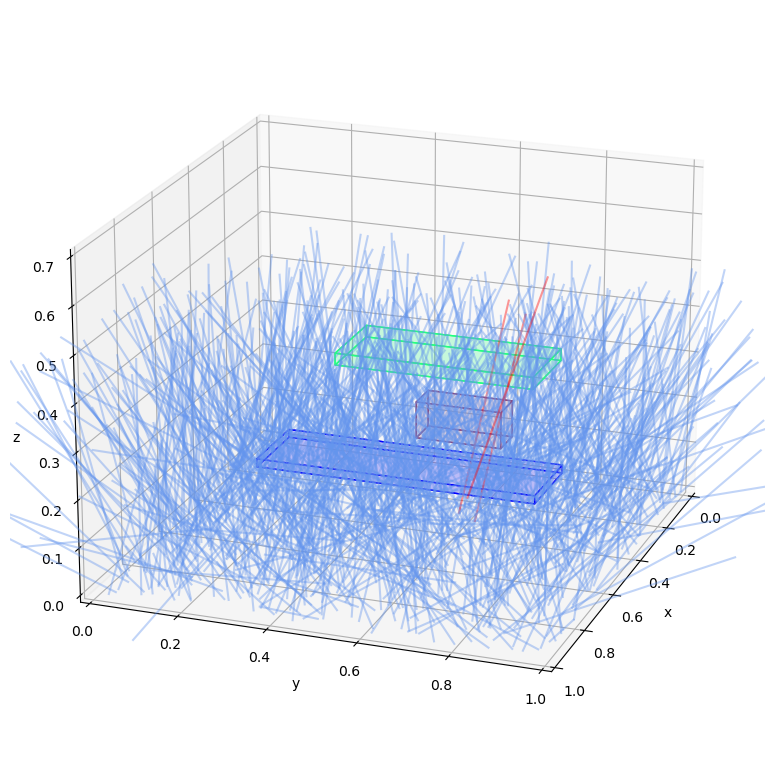

Il numero di raggi che fanno lo stop 110 è 177 / 50000


In [249]:
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 20)

ax.set_xlim3d(xmin, xmax)
ax.set_ylim3d(ymin, ymax)
ax.set_zlim3d(zmin, zmax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.quiver(xs[:n], ys[:n], zs[:n], us[:n], vs[:n], ws[:n], length=0.5, arrow_length_ratio=0,
normalize=True, color=colors_110, alpha=0.4)

#ax.scatter(top_csx_plane[hits_110],top_csy_plane[hits_110], top_csz_plane[hits_110], s=4, color='red')
#ax.scatter(top_upx_plane[hits_110],top_upy_plane[hits_110], top_upz_plane[hits_110], s=4, color='red')
#ax.scatter(top_dwx_plane[hits_110],top_dwy_plane[hits_110], top_dwz_plane[hits_110], s=4, color='red')


sdw_plt= createSolid([a_dw,b_dw,c_dw],[x0_dw,y0_dw,z0_dw], getImpactPlane = False, N = n)
ax.add_collection3d(sdw_plt)

sup_plt= createSolid([a_up,b_up,c_up],[x0_up,y0_up,z0_up], fillColor = "#24ff8120", edgeColor = '#24ff81',
                         getImpactPlane = False, N= n)
ax.add_collection3d(sup_plt)

csi_plt = createSolid([a_cs,b_cs,c_cs], [x0_cs,y0_cs,z0_cs], fillColor = "#884e8420", edgeColor = '#884e84', 
                        getImpactPlane = False, N= n)
ax.add_collection3d(csi_plt)

plt.show()

print('Il numero di raggi che fanno lo stop 110 è', np.count_nonzero(hits_110), '/', hits_110.shape[0])

In [250]:
a_dw, b_dw, c_dw  = 0.201,0.665,0.018
x0_dw, y0_dw, z0_dw = 0,0.05,0
a_up,b_up,c_up = 0.201,0.466,0.026
x0_up,y0_up,z0_up = 0,0.242,0.252
a_cs,b_cs, c_cs = 0.08,0.20,0.08
x0_cs,y0_cs,z0_cs = 0.09,0.424,0.101

quotasup_cs = z0_cs + c_cs
quotainf_cs = z0_cs
quotasup_up = z0_up + c_up
quotainf_up = z0_up
quotasup_dw = z0_dw + c_dw
quotainf_dw = z0_dw

#xs, ys, zs = np.random.uniform(0,1,n), np.random.uniform(0,1,n), np.zeros(n)

#Prendiamo i punti dei raggi che partono dai punti del dw  arrivano alle quote degli altri scintillatori
top_upx_plane = xs + quotasup_up*us/ws 
top_upy_plane = ys + quotasup_up*vs/ws
top_upz_plane = np.full(N, quotasup_up)

top_csx_plane = xs + quotasup_cs*us/ws 
top_csy_plane = ys + quotasup_cs*vs/ws
top_csz_plane = np.full(N, quotasup_cs)

top_dwx_plane = xs + quotasup_dw*us/ws
top_dwy_plane = ys + quotasup_dw*vs/ws
top_dwz_plane = np.full(N, quotasup_dw)

hits_010 = (  ((top_upx_plane < x0_up)           + 
               (top_upx_plane > (x0_up +a_up)))  +
              ((top_upy_plane < y0_up)           + 
               (top_upy_plane > (y0_up +b_up))) &

              
               (x0_cs         < top_csx_plane)   &
               (top_csx_plane < (x0_cs + a_cs))  &
               (y0_cs         < top_csy_plane)   &
               (top_csy_plane < (y0_cs + b_cs))  &
              
            (  (top_dwx_plane < x0_dw)           + 
               (top_dwx_plane > (x0_dw +a_dw)))  +
            (  (top_dwy_plane < y0_dw)           + 
               (top_dwy_plane > (y0_dw +b_dw))))



colors_010 = ["red" if hit else "cornflowerblue" for hit in hits_010]


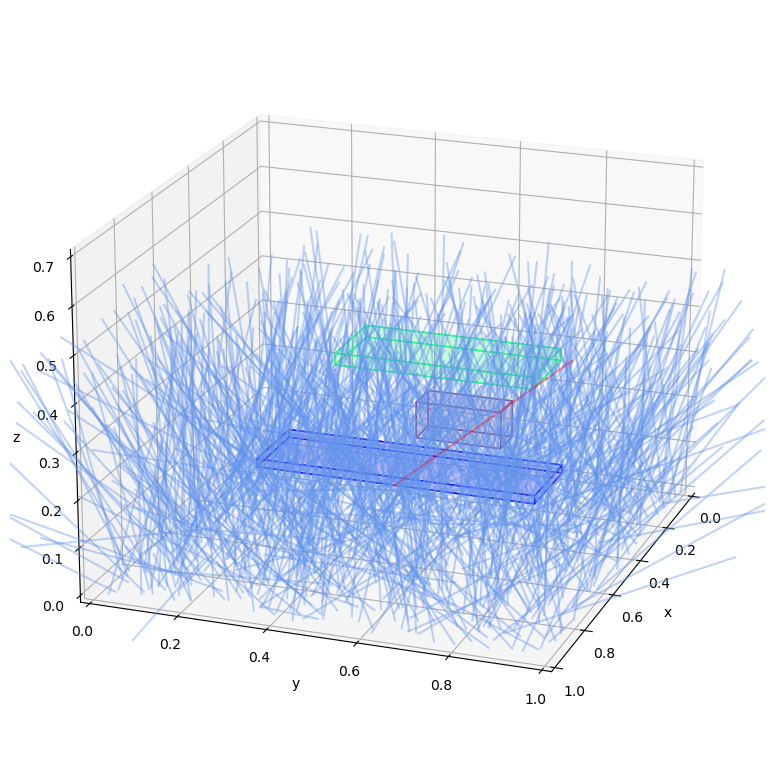

Il numero di raggi che fanno lo stop 010 è 54 / 50000


In [251]:
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 20)

ax.set_xlim3d(xmin, xmax)
ax.set_ylim3d(ymin, ymax)
ax.set_zlim3d(zmin, zmax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.quiver(xs[:n], ys[:n], zs[:n], us[:n], vs[:n], ws[:n], length=0.5, arrow_length_ratio=0,
normalize=True, color=colors_010, alpha=0.4)

#ax.scatter(top_csx_plane[hits_010],top_csy_plane[hits_010], top_csz_plane[hits_010], s=4, color='red')
#ax.scatter(top_upx_plane[hits_010],top_upy_plane[hits_110], top_upz_plane[hits_110], s=4, color='red')
#ax.scatter(top_dwx_plane[hits_110],top_dwy_plane[hits_110], top_dwz_plane[hits_110], s=4, color='red')


sdw_plt= createSolid([a_dw,b_dw,c_dw],[x0_dw,y0_dw,z0_dw], getImpactPlane = False, N = n)
ax.add_collection3d(sdw_plt)

sup_plt= createSolid([a_up,b_up,c_up],[x0_up,y0_up,z0_up], fillColor = "#24ff8120", edgeColor = '#24ff81',
                         getImpactPlane = False, N= n)
ax.add_collection3d(sup_plt)

csi_plt = createSolid([a_cs,b_cs,c_cs], [x0_cs,y0_cs,z0_cs], fillColor = "#884e8420", edgeColor = '#884e84', 
                        getImpactPlane = False, N= n)
ax.add_collection3d(csi_plt)

plt.show()

print('Il numero di raggi che fanno lo stop 010 è', np.count_nonzero(hits_010), '/', hits_010.shape[0])

In [252]:
a_dw, b_dw, c_dw  = 0.201,0.665,0.018
x0_dw, y0_dw, z0_dw = 0,0.05,0
a_up,b_up,c_up = 0.201,0.466,0.026
x0_up,y0_up,z0_up = 0,0.242,0.252
a_cs,b_cs, c_cs = 0.08,0.20,0.08
x0_cs,y0_cs,z0_cs = 0.09,0.424,0.101

quotasup_cs = z0_cs + c_cs
quotainf_cs = z0_cs
quotasup_up = z0_up + c_up
quotainf_up = z0_up
quotasup_dw = z0_dw + c_dw
quotainf_dw = z0_dw

#xs, ys, zs = np.random.uniform(0,1,n), np.random.uniform(0,1,n), np.zeros(n)

#Prendiamo i punti dei raggi che partono dai punti del dw  arrivano alle quote degli altri scintillatori
top_upx_plane = xs + quotasup_up*us/ws 
top_upy_plane = ys + quotasup_up*vs/ws
top_upz_plane = np.full(N, quotasup_up)

top_csx_plane = xs + quotasup_cs*us/ws 
top_csy_plane = ys + quotasup_cs*vs/ws
top_csz_plane = np.full(N, quotasup_cs)

top_dwx_plane = xs + quotasup_dw*us/ws
top_dwy_plane = ys + quotasup_dw*vs/ws
top_dwz_plane = np.full(N, quotasup_dw)

hits_01X = (  ((top_upx_plane < x0_up)           + 
               (top_upx_plane > (x0_up +a_up)))  +
              ((top_upy_plane < y0_up)           + 
               (top_upy_plane > (y0_up +b_up))) &

              
               (x0_cs         < top_csx_plane)   &
               (top_csx_plane < (x0_cs + a_cs))  &
               (y0_cs         < top_csy_plane)   &
               (top_csy_plane < (y0_cs + b_cs)))
              
        


colors_01X = ["red" if hit else "cornflowerblue" for hit in hits_01X]

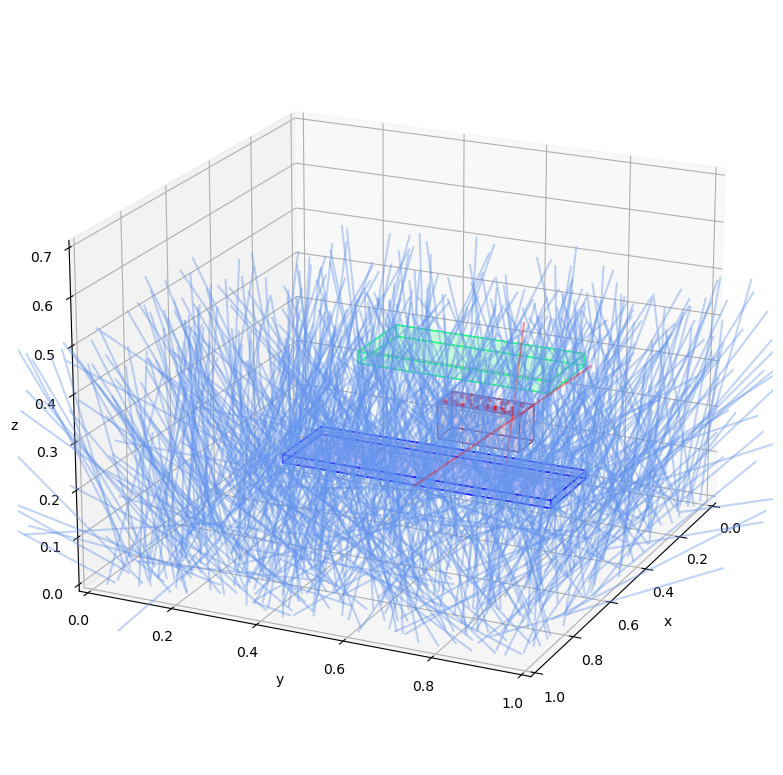

Il numero di raggi che fanno lo stop 01X è 91 / 50000


In [253]:
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 25)

ax.set_xlim3d(xmin, xmax)
ax.set_ylim3d(ymin, ymax)
ax.set_zlim3d(zmin, zmax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.quiver(xs[:n], ys[:n], zs[:n], us[:n], vs[:n], ws[:n], length=0.5, arrow_length_ratio=0,
normalize=True, color=colors_01X, alpha=0.4)

ax.scatter(top_csx_plane[hits_01X],top_csy_plane[hits_01X], top_csz_plane[hits_01X], s=4, color='red')
#ax.scatter(top_upx_plane[hits_010],top_upy_plane[hits_110], top_upz_plane[hits_110], s=4, color='red')
#ax.scatter(top_dwx_plane[hits_110],top_dwy_plane[hits_110], top_dwz_plane[hits_110], s=4, color='red')


sdw_plt= createSolid([a_dw,b_dw,c_dw],[x0_dw,y0_dw,z0_dw], getImpactPlane = False, N = n)
ax.add_collection3d(sdw_plt)

sup_plt= createSolid([a_up,b_up,c_up],[x0_up,y0_up,z0_up], fillColor = "#24ff8120", edgeColor = '#24ff81',
                         getImpactPlane = False, N= n)
ax.add_collection3d(sup_plt)

csi_plt = createSolid([a_cs,b_cs,c_cs], [x0_cs,y0_cs,z0_cs], fillColor = "#884e8420", edgeColor = '#884e84', 
                        getImpactPlane = False, N= n)
ax.add_collection3d(csi_plt)

plt.show()

print('Il numero di raggi che fanno lo stop 01X è', np.count_nonzero(hits_01X), '/', hits_01X.shape[0])

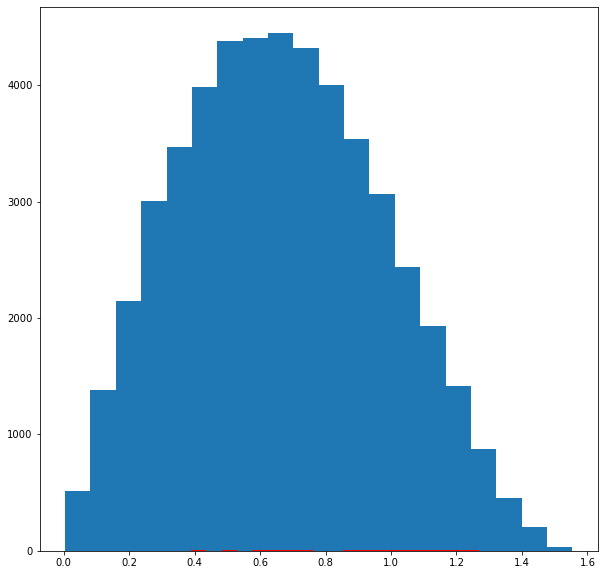

In [256]:
plt.figure(figsize  = (10,10))
plt.hist(thetas, bins = 20)
plt.hist(thetas[hits_01X], bins = 20, color = "red")
plt.show()

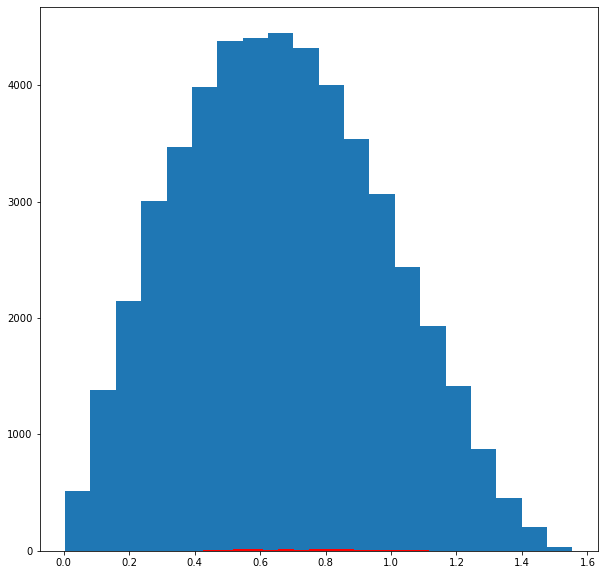

In [257]:
plt.figure(figsize  = (10,10))
plt.hist(thetas, bins = 20)
plt.hist(thetas[hits_110], bins = 20, color = "red")
plt.show()

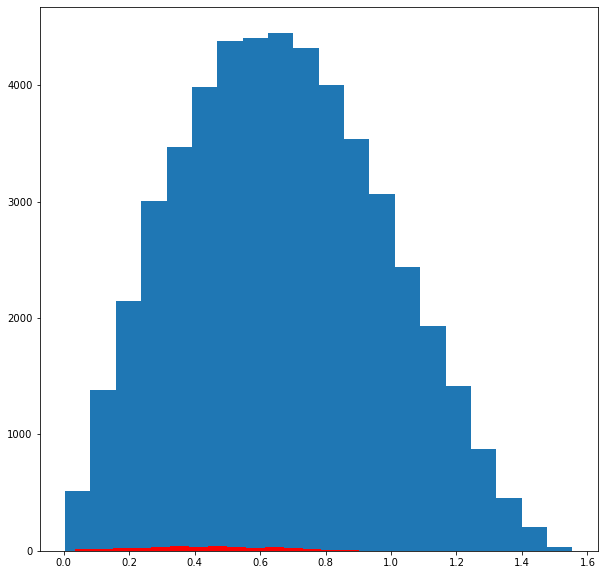

In [258]:
plt.figure(figsize  = (10,10))
plt.hist(thetas, bins = 20)
plt.hist(thetas[hits_plane], bins = 20, color = "red")
plt.show()

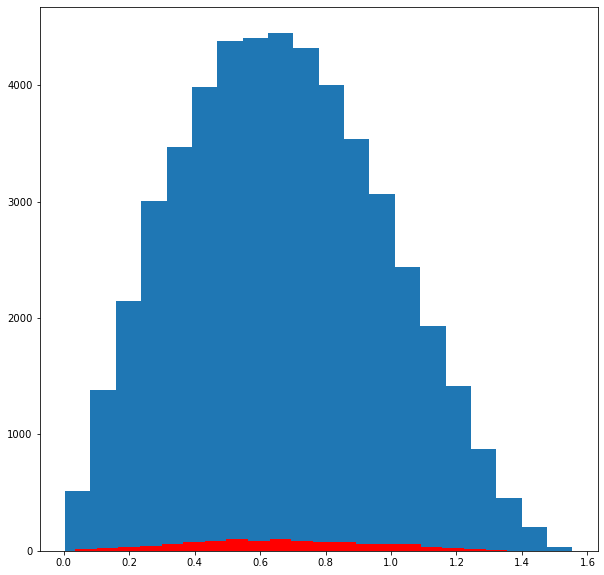

In [259]:
plt.figure(figsize  = (10,10))
plt.hist(thetas, bins = 20)
plt.hist(thetas[hits_cs_plane], bins = 20, color = "red")

plt.show()